<img src="resources/header.png"/>

### Setting up the Jupyter environment

In [14]:
%load_ext jupyter_probcomp.magics

The jupyter_probcomp.magics extension is already loaded. To reload it, use:
  %reload_ext jupyter_probcomp.magics


In [15]:
%matplotlib inline
%vizgpm inline

<IPython.core.display.Javascript object>

### Creating a BayesDB `.bdb` file on disk

In [16]:
#!rm -f resources/ehr_sim_2.bdb
%bayesdb resources/ehr_sim_2.bdb

u'Loaded: resources/ehr_sim_2.bdb'

### Ingesting data from a `.csv` file into a BayesDB table

In [17]:
%bql CREATE TABLE "ds" FROM 'data/fictional_prototype.csv'

Table already exists: 'ds'


In [18]:
%bql .nullify ds ''

Nullified 0 cells


### Running basic queries on the table using BQL and SQL

In [19]:
%bql SELECT * FROM "ds" LIMIT 5;

,id,gender,age_group,encounter_id,encounter_class,encounter_type,event_type,event_title,event_detail,event_year,event_month,start_day,end_day,duration_days,location_map_id
0,1AB5C92,Female,25 - 29,42230255,Inpatient,Inpatient Acute,Encounter Only,"Child, Youth & Family",Maternity,2013,1,660,662,2,1673
1,1AB5C92,Female,25 - 29,20125520,Inpatient,MHAS - Residential,Encounter Only,Mental Health,Adult Psychiatry,2015,12,1594,1614,20,874
2,1AB5C92,Female,25 - 29,36191729,Inpatient,MHAS - Acute Care,Encounter Only,Mental Health,Adult Psychiatry,2011,6,31,48,17,903
3,1AB5C92,Female,25 - 29,86996036,Recurring,Open Encounter,Encounter Only,Mental Health,Adult Psychiatry,2016,5,11,165,154,601
4,1AB5C92,Female,25 - 29,55289445,Recurring,Open Encounter,Encounter Only,Mental Health,Adult Psychiatry,2009,7,0,810,810,1261


We can also find the total number of records (i.e. countries).

In [20]:
%bql SELECT COUNT(*) FROM "ds";

,"""COUNT""(*)"
0,325


### Creating a BayesDB population for the Gapminder data

In [21]:
%mml GUESS SCHEMA FOR "ds"

,column,stattype,num_distinct,reason
0,id,nominal,10,The values are nonnumerical.
1,gender,nominal,2,The values are nonnumerical.
2,age_group,nominal,7,The values are nonnumerical.
3,encounter_id,numerical,220,There are at least 20 unique numerical values...
4,encounter_class,nominal,6,The values are nonnumerical.
5,encounter_type,nominal,10,The values are nonnumerical.
6,event_type,nominal,6,The values are nonnumerical.
7,event_title,nominal,10,The values are nonnumerical.
8,event_detail,nominal,80,The values are nonnumerical.
9,event_year,nominal,10,There are fewer than 20 distinct numerical va...


In [22]:
%%mml
DROP METAMODEL IF EXISTS "ehr_schema";
DROP POPULATION IF EXISTS "ehr_population";
CREATE POPULATION "ehr_population" FOR "ds" WITH SCHEMA (
    -- Use the guesses from the previous cell for all variables.
    GUESS STATTYPES FOR (*);

    -- Manually override incorrectly guessed statistical types.
    MODEL
    "encounter_id", "location_map_id"
    AS NOMINAL;
);

""


### Creating an analysis schema for the population using CrossCat

In [23]:
%mml CREATE ANALYSIS SCHEMA "ehr_schema" FOR "ehr_population" WITH BASELINE crosscat();

""


After specifying the `ehr_schema` analysis schema, we now need to initialize `ANALYSES` for the schema. We can think of an `ANALYSIS SCHEMA` as specifying a hypothesis space of explanations for the data generating process for the population, and each `ANALYSIS` is a candidate hypothesis. We start by creating only 1 analysis, which is initialized __randomly__.

In [24]:
%mml INITIALIZE 32 ANALYSIS FOR "ehr_schema";

""


### Using BQL to query CrossCat models

In [25]:
%bql .interactive_heatmap ESTIMATE DEPENDENCE PROBABILITY FROM PAIRWISE VARIABLES OF ehr_population;

<IPython.core.display.Javascript object>

### Improving Crosscat hypotheses using MML `ANALYZE`

In [26]:
%multiprocess on
import time

start = time.time()
for i in range(5):
    print i
    %mml ANALYZE "ehr_schema" FOR 1000 ITERATIONS WAIT (OPTIMIZED);
    end = time.time()
    print 'elapsed = %s' % (end-start)

Multiprocessing turned on from off.
0
Completed: 1000 iterations in 270.800277 seconds.
Completed: 1000 iterations in 302.370852 seconds.
Completed: 1000 iterations in 305.193932 seconds.
Completed: 1000 iterations in 305.642898 seconds.
Completed: 1000 iterations in 308.581548 seconds.
Completed: 1000 iterations in 311.817513 seconds.
Completed: 1000 iterations in 313.825451 seconds.
Completed: 1000 iterations in 347.897187 seconds.
Completed: 1000 iterations in 353.126159 seconds.
Completed: 1000 iterations in 371.838956 seconds.
elapsed = 377.750384092
1
Completed: 1000 iterations in 302.197135 seconds.
Completed: 1000 iterations in 302.487561 seconds.
Completed: 1000 iterations in 306.693234 seconds.
Completed: 1000 iterations in 311.108525 seconds.
Completed: 1000 iterations in 313.767776 seconds.
Completed: 1000 iterations in 314.105441 seconds.
Completed: 1000 iterations in 333.456297 seconds.
Completed: 1000 iterations in 334.646916 seconds.
Completed: 1000 iterations in 335.25

In [46]:
%bql .interactive_heatmap ESTIMATE DEPENDENCE PROBABILITY FROM PAIRWISE VARIABLES OF ehr_population;

<IPython.core.display.Javascript object>

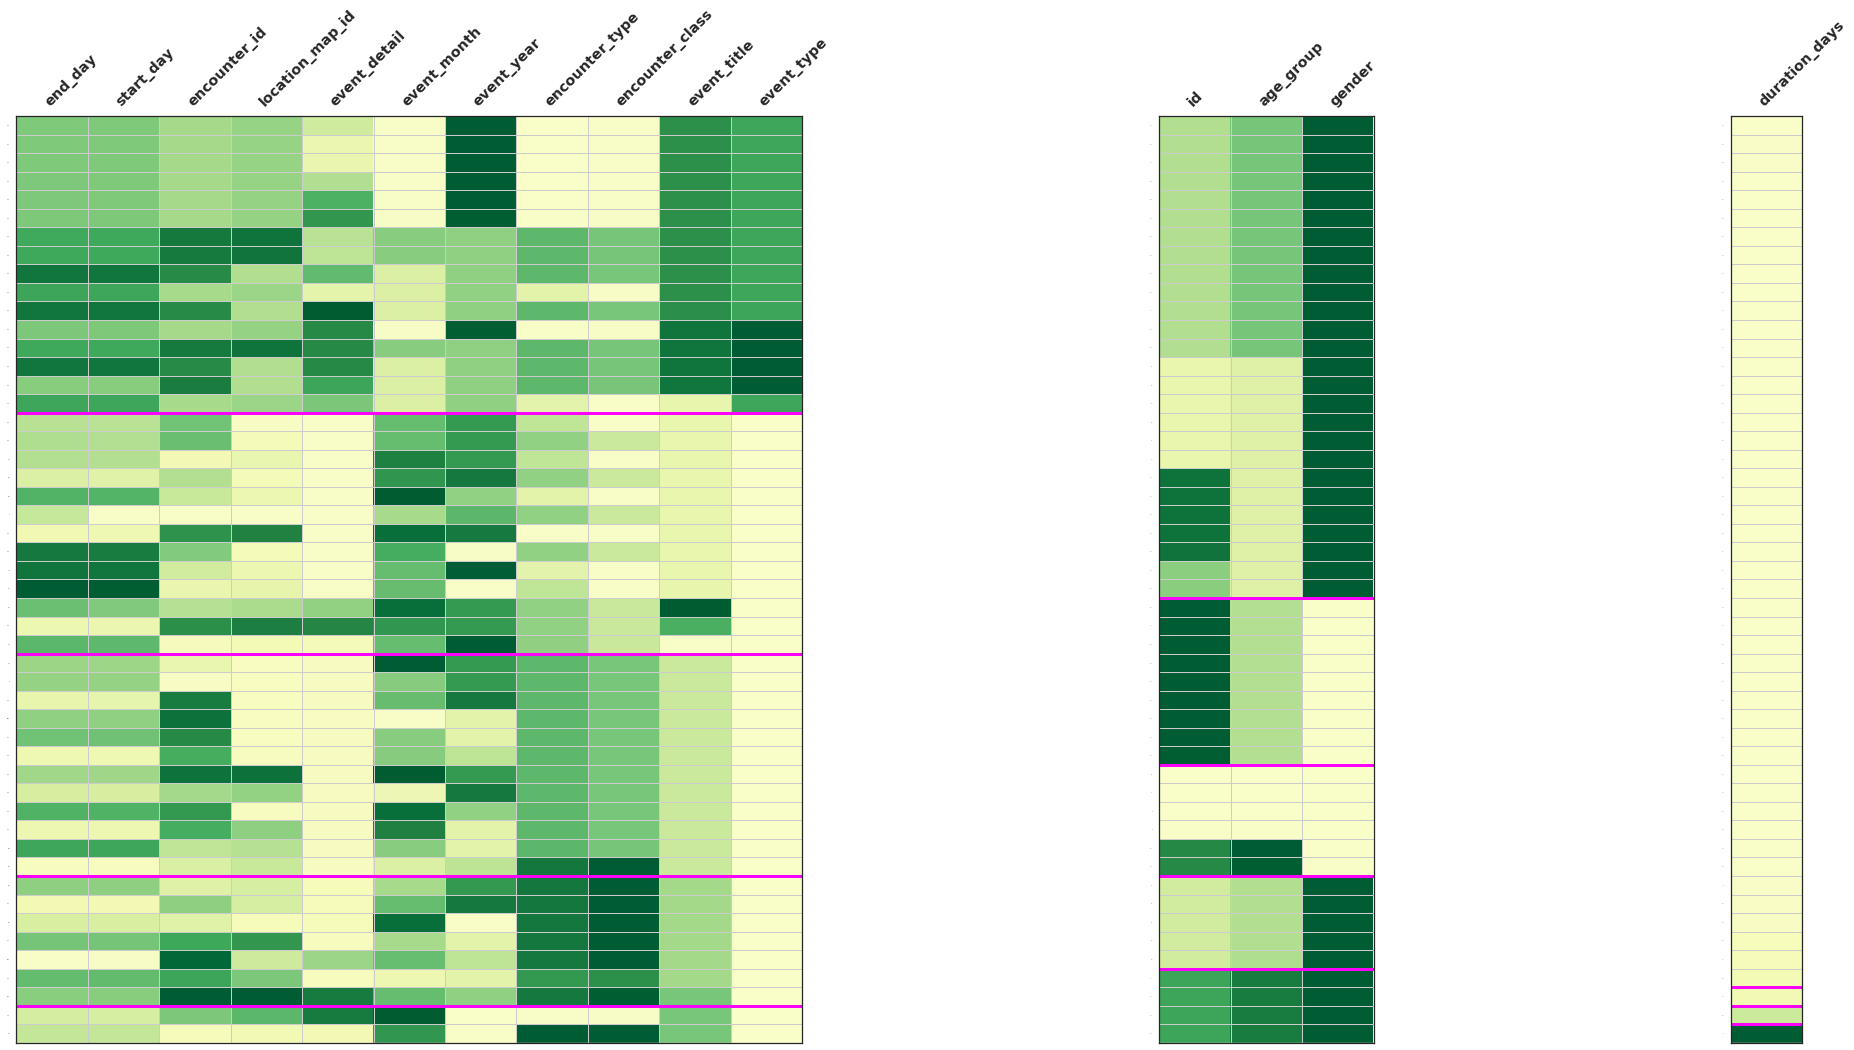

In [47]:
%mml .render_crosscat \
    --subsample=50\
    ehr_schema 0

## SIMULATE

In [48]:
%bql ESTIMATE * FROM ehr_population LIMIT 1

,id,gender,age_group,encounter_id,encounter_class,encounter_type,event_type,event_title,event_detail,event_year,event_month,start_day,end_day,duration_days,location_map_id
0,1AB5C92,Female,25 - 29,42230255,Inpatient,Inpatient Acute,Encounter Only,"Child, Youth & Family",Maternity,2013,1,660,662,2,1673


In [49]:
df = %bql ESTIMATE * FROM ehr_population LIMIT 1
column_names_to_simulate = ', '.join(['"%s"' % s for s in list(set(df.columns.values) - set(['event_start_date', 'event_end_date']))])
print column_names_to_simulate

"start_day", "encounter_class", "event_title", "gender", "event_year", "id", "event_detail", "age_group", "end_day", "encounter_type", "location_map_id", "duration_days", "event_month", "encounter_id", "event_type"


In [50]:
%bql CREATE TABLE simulated_data AS SIMULATE {column_names_to_simulate} FROM ehr_population LIMIT 325

Name already defined as table: 'simulated_data'


In [51]:
%sql SELECT * FROM simulated_data LIMIT 10

,start_day,encounter_class,event_title,gender,event_year,id,event_detail,age_group,end_day,encounter_type,location_map_id,duration_days,event_month,encounter_id,event_type
0,3207.980434,Inpatient,NA,Male,2016,DC2302,XR Chest 2 Views,45 - 49,1907.169806,Emergency,1631,-3.589642,10,87256532,General Lab
1,1298.717220,Inpatient,Mental Health,Female,2013,2D98203,Adult Psychiatry,35 - 39,1692.194521,Open Encounter,1612,6.562788,10,29904969,Encounter Only
2,523.655585,Inpatient,Mental Health,Female,2013,2D98203,Hepatitis C Antibody,35 - 39,1465.536749,MHAS - Acute Care,167,15.021638,11,25603783,Encounter Only
3,1527.423947,Outpatient,NA,Female,2017,2D98203,Chem 7 Hem Careset,35 - 39,785.797991,Emergency,1448,22.589584,1,19902049,General Lab
4,243.595179,Emergency,NA,Male,2014,7C1DB2,Complete Blood Count and Differential,45 - 49,2122.915602,Emergency,876,-21.057323,6,39815674,Micro
5,1310.330529,Emergency,NA,Female,2012,2D98203,NA,35 - 39,1665.476151,Emergency,876,30.034807,10,25631963,Encounter Only
6,1446.644572,Inpatient,Laboratory,Male,2016,C9B9133,HH ECG Electrocardiogram,45 - 49,2393.367883,MHAS - Residential,934,9.567756,6,89300625,General Lab
7,1718.767185,Emergency,NA,Male,2015,102DBC2,NA,35 - 39,249.095803,Recurring/Series,1264,-0.016521,8,37587106,Encounter Only
8,1014.865136,Inpatient,Mental Health,Female,2015,1AB5C92,CT Wrist w/o Contrast Left,35 - 39,2398.150131,Open Encounter,1499,3.051932,7,91843985,Encounter Only
9,87.219233,Inpatient,Mental Health,Male,2011,2D98203,Adult Psychiatry,35 - 39,817.015229,MHAS - Residential,844,38.759697,4,34221331,Encounter Only


In [52]:
import pandas as pd
df = %sql SELECT * FROM simulated_data
df.to_csv('simulation_results2.csv', index=False)

## SELECT vs SIMULATE

(-500, 500)

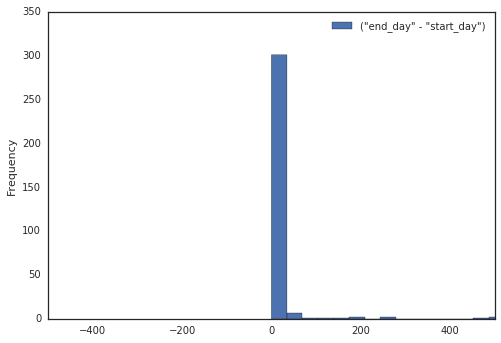

In [53]:
df = %bql SELECT end_day-start_day FROM ds
plt = df.plot.hist(bins=100)
plt.set_xlim([-500, 500])

(-500, 500)

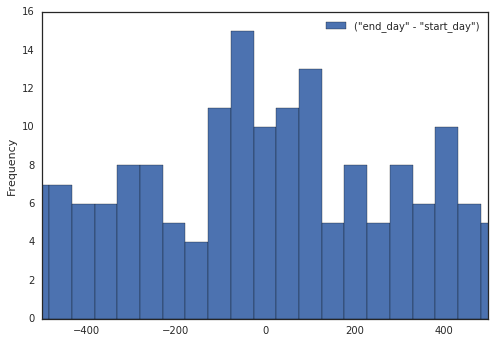

In [54]:
df = %bql SELECT end_day-start_day FROM simulated_data
plt = df.plot.hist(bins=100)
plt.set_xlim([-500, 500])

In [70]:
%%bql
.interactive_pairplot --population=ehr_population 
SELECT
"event_year",
"event_month",
"end_day",
"start_day"
FROM ds

<IPython.core.display.Javascript object>

In [71]:
%%bql
.interactive_pairplot --population=ehr_population 
SELECT
"event_year",
"event_month",
"end_day",
"start_day"
FROM simulated_data

<IPython.core.display.Javascript object>

In [72]:
%%bql
.interactive_pairplot --population=ehr_population 
SELECT
"end_day",
"start_day",
"duration_days"
FROM ds

<IPython.core.display.Javascript object>

In [56]:
%%bql
.interactive_pairplot --population=ehr_population 
SELECT
"end_day",
"start_day",
"duration_days"
FROM simulated_data

<IPython.core.display.Javascript object>

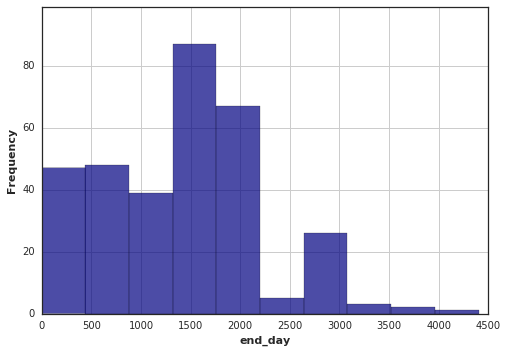

In [57]:
%bql .histogram_numerical SELECT end_day FROM ds

In [67]:
%%bql
.interactive_pairplot --population=ehr_population 
SELECT
"gender",
"age_group",
"encounter_class",
"event_type"
FROM ds

<IPython.core.display.Javascript object>

In [68]:
%%bql
.interactive_pairplot --population=ehr_population 
SELECT
"gender",
"age_group",
"encounter_class",
"event_type"
FROM simulated_data

<IPython.core.display.Javascript object>

In [65]:
%%bql
.interactive_pairplot --population=ehr_population 
SELECT
"encounter_type",
"encounter_class",
"event_type",
"event_title"
FROM ds

<IPython.core.display.Javascript object>

In [66]:
%%bql
.interactive_pairplot --population=ehr_population 
SELECT
"encounter_type",
"encounter_class",
"event_type",
"event_title"
FROM simulated_data

<IPython.core.display.Javascript object>

# Conclusions and next steps

* It is possible to simulate EHR data using BayesDB and this appears to preserve the frequencies with which values appear, as well as certain second order relationships between variables

* A next step is to use Venture to force certain variable relationships to take a specified functional form, for example that a single patient ID can only have one gender.

* We may further improve the match between real and simulated EHR data by running analysis for a longer time. This tradeoff can be made precise using a runtime-accuracy analysis.

* It is very easy to simulate data in a .csv file using BayesDB: the simulation step takes just one line of code

## Slides
* Who you are and where this data comes from
* A slide describing the rows and columns 
* A slide listing total runtime and CrossCat models (and maybe the analysis step code)
* A slide showing dependencies heatmap
* A slide comparing SELECT to SIMULATE showing 1st order structure (counts of different categories, histogram of numerical variables) is preserved
* A slide showing that certain second order sturcutre (between pairs of variables) is preserved:
    - male female vs age group
    - event type and encounter class, etc
* End day minus start day - second order relationship preserved (in probability) even if that difference was not in the original data set
* Conclusions and next steps with text above